<a href="https://colab.research.google.com/github/Hernanros/NLP-Ydata/blob/master/HW4/HW4_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW-4 - Predicting Sentence Similarity
In lecture 4 we saw several techniques for sentence embedding. The most simple one which also leads to competitive results is simply taking the average of pre-trained word embedding. Therefore, in this exercise, we will explore the STS dataset and we will see how can we improve the existing word embedding to better handle this task.


## 1 - Package installation

For some of the methods below, we also need the word frequencies estimated from the corpus. As we currently don't have this available for the GloVe pretrained vectors / Common Crawl corpus, we use the wordfreq package (https://github.com/LuminosoInsight/wordfreq/)

The SemEval data are obtained from the datasets-sts repo: https://github.com/brmson/dataset-sts

GloVe - Global Vectors for Word Representation (https://nlp.stanford.edu/projects/glove/). Pre-trained word vectors have been downloaded (we use the 300-dimensional vectors trained on the 840 billion token Common Crawl corpus: http://nlp.stanford.edu/data/glove.840B.300d.zip) - *The download may take a while*

In [1]:
!pip install wordfreq
!git clone https://github.com/brmson/dataset-sts
!wget  http://nlp.stanford.edu/data/glove.840B.300d.zip

     |████████████████████████████████| 32.8MB 104kB/s 
     |████████████████████████████████| 4.9MB 35.7MB/s 
     |████████████████████████████████| 276kB 25.6MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.3.2-cp36-none-any.whl size=32817238 sha256=32662b21e3dadb471f7eb383ee89fa6abb8d9a6201cba08dd325f87c290ef0f9
  Stored in directory: /root/.cache/pip/wheels/8d/ba/84/ba6be76208bd2c2124b6586f7967fb87e9f9fb4b4827e5e2c9
  Created wheel for langcodes: filename=langcodes-2.0.0-cp36-none-any.whl size=5044047 sha256=1bc966a8a8783c15f187e344782959a044b79349de3634b75c8d23328d2cffab
  Stored in directory: /root/.cache/pip/wheels/c9/11/90/c7bba8118f3674d75e1457537635266a12538cf622a4684bb2
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=861349 sha256=16746ba25c2d0c6febc5f8af97b804f957412ef334d57111208aab277805b50c
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
Successfully built wor

We will convert the downloaded word embedding to a dictionary for further usage.

In [0]:
import pandas as pd
import zipfile

z = zipfile.ZipFile("./glove.840B.300d.zip")
glove_pd = pd.read_csv(z.open('glove.840B.300d.txt'), sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in glove_pd.T.items()}
del glove_pd



After this you can easily access the word embedding by accessing a dictionary

In [3]:
glove['test']

array([ 6.1149e-02,  2.6721e-01,  2.1774e-01, -8.3348e-02, -2.6133e-01,
       -3.9486e-01,  1.5583e-01,  6.6879e-02,  2.0870e-01,  1.4234e+00,
       -1.0804e-02, -1.9882e-01,  3.9469e-01,  1.5281e-01, -5.3483e-02,
       -1.5038e-01,  7.6048e-02,  2.3503e+00, -5.4424e-01,  6.6730e-02,
        2.7928e-01,  1.9309e-02,  1.9913e-01,  1.5012e-01,  6.7792e-02,
        4.2240e-01,  6.4592e-02, -4.2206e-01,  3.6131e-01, -6.6089e-02,
       -8.7619e-03, -1.6498e-01,  1.0331e+00,  7.3610e-03,  4.9780e-02,
        3.5465e-01, -4.8489e-02,  4.3285e-01, -2.8666e-01,  1.7611e-02,
        3.6812e-01, -3.9362e-01, -1.2477e-02,  5.7482e-02,  1.1698e-01,
       -1.9191e-01, -3.2016e-02,  4.5280e-01,  1.8469e-01,  9.2373e-03,
        2.8163e-02, -7.1910e-02, -8.1790e-02, -2.2027e-01, -4.2260e-01,
       -1.5531e-02,  1.2467e-03, -1.1923e-01, -1.1214e-03, -8.8915e-02,
        1.1482e-01,  2.2836e-01,  2.0428e-02,  6.8038e-01,  5.8773e-01,
        5.3019e-01,  2.3912e-01, -3.6659e-01,  3.6670e-02,  5.14

If we want to acess the frequency of a specific word it can be done easily using wordfreq (note that in general it would have been better to calculate the word frequency based on our on corpus)

In [4]:
import wordfreq
wordfreq.word_frequency('test', 'en', wordlist='large')

0.000158

## 2 - Loading the datasets


In [26]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import sys
sys.path.append('./dataset-sts/')
import pysts
from pysts.loader import load_sts
from scipy.stats import pearsonr

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now we will load the 2015 STS dataset on the healines segement. As you can see each example is composed by two sentences s0 and s1 and a label

In [0]:
s0, s1, labels = load_sts("dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv")

In [7]:
print(f"Sentence A: {s0[0]}")
print(f"Sentence B: {s1[0]}")
print(f"Label: {labels[0]}")


Sentence A: ['The', 'foundations', 'of', 'South', 'Africa', 'are', 'built', 'on', 'Nelson', 'Mandela', "'s", 'memory']
Sentence B: ['Australian', 'politicians', 'lament', 'over', 'Nelson', 'Mandela', "'s", 'death']
Label: 1.3


In [0]:
s2i = {w:i for i, w in enumerate(glove.keys())}


## 3. Predict similarity between sentences based on GloVe
To predict the similarity between two sentences, the word embeddings (using the GloVe word vectors) are combined into a sentence embedding.

Similarity is calculate as the cosine similarity of the two sentence embeddings, and the overall performance is evaluated as the Pearson's coefficient between the predicted scores and the labels.



In [0]:
# Implement the following functions:
# 1.  A function which gets as an input a sentence and returns the average of it's word embedding.
def mean_embedding (sent):
  embs = []
  for word in sent:
    try: 
      embs.append(glove[word.lower()])
    except:
      try:
        embs.append(glove[word.strip("'")])
      except:
        embs.append([0]*300)

  return np.mean(embs,axis = 0)

# 2.  A function which gets as an input two sentence embeddings and returns their cosine-similarity
def cossim (emb1, emb2):
  return emb1@emb2/(np.linalg.norm(emb1)*np.linalg.norm(emb2))

# 3.  A function which gets the the predicted scores and the labels and returns the pearson's r coefficent Tip: For calculating the pearson's r coefficent you can use from scipy.stats import pearsonr
def calc_pears (predicted, real):
  return pearsonr(predicted,real)[0]

You can check the implementation using a small batch of the data

In [0]:
Small_batch = (s0[:10],s1[:10])

In [105]:
glove['posessor']

KeyError: ignored

In [0]:
emb0 = [mean_embedding(Small_batch[1][i]) for i in range(len(Small_batch[0]))]

In [99]:
calc_pears([cossim(mean_embedding(Small_batch[0][i]),mean_embedding(Small_batch[1][i])) for i in range(len(Small_batch[0]))],labels[:10])

0.7188678461506433

Now we will evaluate the method across all the STS datasets using the following function which loops over all the datasets. The desired output is a table which shows Pearson's coefficent on each dataset.

In [110]:
files = glob.glob("dataset-sts/data/sts/semeval-sts/all/*.test.tsv")

def evaluate_tasks(files, embed_func):

    tests = []
    scores = []

    for f in files:
        s0, s1, labels = load_sts(f)
        sims = [cossim(embed_func(s0[i]),embed_func(s1[i])) for i in range (len(s0))]
        tests.append(sims)
        scores.append (calc_pears(sims, labels))
    return np.concatenate((tests,scores),axis =0)


evaluate_tasks(files, mean_embedding)

array([list([0.9033766025177961, 0.9495835365352053, 0.8888328301648649, 0.8600742104227476, 0.7903811613965047, 0.8819447320953393, 0.9220429495487837, 0.7728346727818673, 0.8649340116096579, 0.8809435638378047, 0.9023645872535169, 0.9126062706273759, 0.8500132482741117, 0.7835348503532749, 0.7531641051929678, 0.9619111369539304, 0.8998892967224413, 0.8322889340325065, 0.9205421420584531, 0.979910087202412, 0.9123631391520368, 0.887695277247096, 0.8414741858792385, 0.8448323258754719, 0.9424327034768551, 0.9256273305606648, 0.844686052882561, 0.9771501810396255, 0.9193857810208719, 0.9242135748773047, 0.982035549555149, 0.8977280745444225, 0.7815961955697925, 0.9359553481193322, 0.905538447740593, 0.9889114339438041, 0.9543382528498673, 0.9027520799901675, 0.9540886646374912, 0.8306618821274397, 0.9179828168246669, 0.7797596373575424, 0.9372740708558298, 0.80105756750252, 0.941190513199191, 0.9117871776006345, 0.8454737020622186, 1.0, 0.9849022524325802, 0.9007479050423861, 0.97981924

## 4. Predict similarity between sentences based on inverse-frequency weighted GloVe

Now we will see how we can improve our embedding using inverse-frequency weighted average. Which means that instead of taking regular average we will now take a weighted avarage where the weight for each word will be it's inverse frequency. 

We remind you that the word frequency can be calculated using the wordfreq 
package. As before the final result should be a table with the reported Pearson's coeefiecnt. Place the result from this section next to the results from above so we can spot the diffrences.


TIP: In order to avoid numerical issues instead of multiplying by 1/freq you sould multiply by a / (a + freq) for some small a (e.g. 1e-3)


In [0]:
# Your implementation Here


## 5. Predict similarity between sentences based on  first common component removal

We will add to the weighted average from above the removal of the first common components as suggested by Arora et al. (2017) in the paper A SIMPLE  BUT TOUGH-TO-BEAT BASELINE  FOR SENTENCE EMBEDDINGS (https://openreview.net/pdf?id=SyK00v5xx)

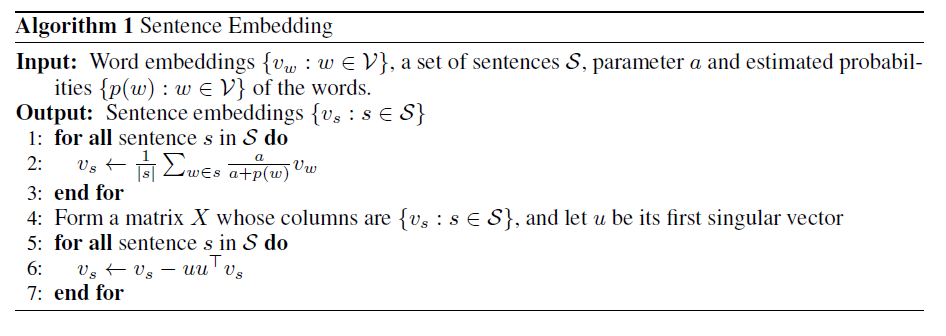

As you can observe we already implmented lines 1-3. So all we have to do is to implment lines 4-6 in the above algorithm.

Place the result from this section next to the results from above so we can spot the diffrences.


In [0]:
# Your implementation Here


## 6. Predict similarity between sentences based on average BERT embeddings

Evaluate the similarity using average BERT embeddings. You are adviced to use the transformers package.

Place the result from this section next to the results from above so we can spot the diffrences.


In [0]:
# Your implementation Here
